# GEMAct: a Python package for non-life (re)insurance modeling

This notebook contains the code blocks shown in the [manuscript](https://arxiv.org/abs/2303.01129) describing the usage and the design of the GEMAct package.
This vignette is relative to the version 1.2.0 of the GEMAct software.

In [1]:
pip install -i https://test.pypi.org/simple/ gemact==1.2.1

Looking in indexes: https://test.pypi.org/simple/
  Using cached https://test-files.pythonhosted.org/packages/62/44/579ef6d82e85dc4408d8f4b79930de19ca7d008642a03b049a61d4cee878/gemact-1.2.1.tar.gz (70 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for gemact: filename=gemact-1.2.1-py3-none-any.whl size=75861 sha256=94ee798f1cbed1bd99dd333bab11d2f1992678bfb6de18db4e38338cac8df0d7
  Stored in directory: c:\users\gpitt\appdata\local\pip\cache\wheels\ac\68\8c\0254909bb666e531869644e31e4b423884a996c9e799198513
Successfully built gemact
Note: you may need to restart the kernel to use updated packages.


## 3.3 Severity discretisation

Mean of the discretised distribution: 5.000000000000088


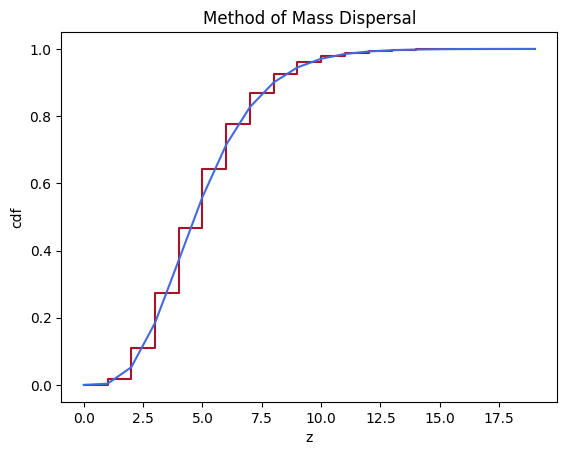

In [2]:
from gemact.lossmodel import Severity
severity = Severity(dist='gamma', par={'a': 5})

massdispersal = severity.discretize(
    discr_method='massdispersal',
    n_discr_nodes=50000,
    discr_step=.01,
    deductible=0
    )

import numpy as np
discrete_mean = np.sum(massdispersal['nodes'] * massdispersal['fj'])
print('Mean of the discretised distribution:', discrete_mean)

from gemact import distributions
dist = distributions.Gamma(a=5)
nodes = np.arange(0, 20)
true_cdf = dist.cdf(nodes)

import matplotlib.pyplot as plt
severity.plot_discr_sev_cdf(
    discr_method='massdispersal',
    n_discr_nodes=20,
    discr_step=1,
    deductible=0,
    color='#a71429'
    )
plt.plot(nodes, true_cdf, color='#4169E1', label='True cdf')
plt.title('Method of Mass Dispersal')
plt.xlabel('z')
plt.show()

## 3.4 Supported distributions

In [3]:
ztpois = distributions.ZTPoisson(mu=2)

random_variates = ztpois.rvs(10**5, random_state=1)
print('Simulated Mean: ', np.mean(random_variates))
print('Exact Mean: ', ztpois.mean())

from gemact import copulas
gumbel_copula = copulas.GumbelCopula(par=1.2, dim=2)
values = np.array([[.5, .5]])
print('Gumbel copula cdf: ', gumbel_copula.cdf(values)[0])

Simulated Mean:  2.3095
Exact Mean:  2.3130352854993315
Gumbel copula cdf:  0.2908208406483879


## 3.5 Illustration lossmodel

In [4]:
from gemact.lossmodel import Frequency
frequency = Frequency(
    dist='poisson',
    par={'mu': 4},
    threshold=0
    )

from gemact.lossmodel import LossModel
lm_mc = LossModel(
    frequency=frequency,
    severity=severity,
    aggr_loss_dist_method='mc',
    n_sim=10**5,
    random_state=1
    )

lm_mc.print_aggr_loss_method_specs()

lm_mc.mean(use_dist=True)
lm_mc.mean(use_dist=False)
lm_mc.coeff_variation(use_dist=True)
lm_mc.coeff_variation(use_dist=False)
lm_mc.skewness(use_dist=True)
lm_mc.skewness(use_dist=False)

lm_mc.moment(central=False, n=1)

lm_mc.ppf(q=[0.80, 0.70])

from gemact.lossmodel import PolicyStructure, Layer
policystructure = PolicyStructure(
    layers=Layer(
    cover=20,
    deductible=5
    ))

lm_XL = LossModel(
    frequency=frequency,
    severity=severity,
    policystructure=policystructure,
    aggr_loss_dist_method='fft',
    sev_discr_method='massdispersal',
    n_aggr_dist_nodes=2**17
    )


lm_XL.print_costing_specs()

lm_XL.mean(use_dist=True)
lm_XL.mean(use_dist=False)
lm_XL.coeff_variation(use_dist=True)
lm_XL.coeff_variation(use_dist=False)
lm_XL.skewness(use_dist=True)
lm_XL.skewness(use_dist=False)

policystructure_RS = PolicyStructure(
    layers=Layer(
    cover=100,
    deductible=0,
    aggr_deductible=100,
    reinst_percentage=1,
    n_reinst=2
    ))

lm_RS = LossModel(
    frequency=Frequency(
    dist='poisson',
    par={'mu': .5}
    ),
    severity=Severity(
    dist='pareto2',
    par={'scale': 100, 'shape': 1.2}
    ),
    policystructure = policystructure_RS,
    aggr_loss_dist_method='fft',
    sev_discr_method='massdispersal',
    n_aggr_dist_nodes=2**17
    )
print('Pure premium (RS): ', lm_RS.pure_premium_dist[0])

policystructure=PolicyStructure(
    layers=[
    Layer(cover=100, deductible=100, share=0.5),
    Layer(cover=200, deductible=100, n_reinst=2, reinst_percentage=0.6),
    Layer(cover=100, deductible=100, aggr_cover=200)
    ])
lossmodel_multiple = LossModel(
    frequency=Frequency(
    dist='poisson',
    par={'mu': .5}
    ),
    severity=Severity(
    dist='genpareto',
    par={'loc': 0, 'scale': 83.34, 'c': 0.834}
    ),
    policystructure=policystructure
    )

lossmodel_multiple.pure_premium
lossmodel_multiple.pure_premium_dist

lossmodel_multiple.dist_calculate(
    aggr_loss_dist_method='fft',
    sev_discr_method='massdispersal',
    n_aggr_dist_nodes=2**17
)
lossmodel_multiple.costing()
lossmodel_multiple.pure_premium
lossmodel_multiple.pure_premium_dist

lossmodel_multiple.print_policy_layer_specs(idx=1)

lossmodel_multiple.mean(idx=2)

INFO:lossmodel|Approximating aggregate loss distribution via Monte Carlo simulation
INFO:lossmodel|MC simulation completed
INFO:lossmodel|Approximating aggregate loss distribution via FFT
INFO:lossmodel|FFT completed
INFO:lossmodel|Approximating aggregate loss distribution via FFT


           Aggregate Loss Distribution: layer 1
                                      Quantity           Value
                   Aggregate loss dist. method              mc
                          Number of simulation          100000
                                  Random state               1
                                          Costing Summary: Layer 1
                                                          Quantity           Value
                                                             Cover            20.0
                                                        Deductible             5.0
                                                   Aggregate cover             inf
                                              Aggregate deductible               0
                   Pure premium (dist est.) before share partecip.            3.51
                               Pure premium before share partecip.            3.51
                                                   S

INFO:lossmodel|FFT completed
INFO:lossmodel|Computation of layers started
INFO:lossmodel|Computing layer: 1
INFO:lossmodel|Approximating aggregate loss distribution via FFT
INFO:lossmodel|FFT completed
INFO:lossmodel|Computing layer: 2
INFO:lossmodel|Approximating aggregate loss distribution via FFT
INFO:lossmodel|FFT completed
INFO:lossmodel|Computing layer: 3
INFO:lossmodel|Approximating aggregate loss distribution via FFT
INFO:lossmodel|FFT completed
INFO:lossmodel|Computation of layers completed


16.88704720494848

# 4.1 Illustration lossaggregation

In [ ]:
from gemact import LossAggregation, Copula, Margins
lossaggregation = LossAggregation(
    margins=Margins(
    dist=['genpareto', 'lognormal'],
    par=[{'loc': 0, 'scale': 1/.9, 'c': 1/.9}, {'loc': 0, 'scale': 10, 'shape': 1.5}]
    ),
    copula=Copula(
    dist='frank',
    par={'par': 1.2, 'dim': 2}
    ),
    n_sim=500000,
    random_state=10,
    n_iter=8
    )

s = 300 # arbitrary value
p_aep = lossaggregation.cdf(x=s, method='aep')
print('P(X1+X2 <= s) = ', p_aep)
p_mc = lossaggregation.cdf(x=s, method='mc')
print('P(X1+X2 <= s) = ', p_mc)

lossaggregation.ppf(q=p_aep, method='aep')
lossaggregation.ppf(q=p_mc, method='mc')

# 5.2 Illustration lossreserve

In [ ]:
from gemact import gemdata
ip = gemdata.incremental_payments_sim
pnb = gemdata.payments_number_sim
cp = gemdata.cased_payments_sim
opn = gemdata.open_number_sim
reported = gemdata.reported_claims_sim
czj = gemdata.czj_sim
from gemact import AggregateData
from gemact import ReservingModel

ad = AggregateData(
    incremental_payments=ip,
    cased_payments=cp,
    open_claims_number=opn,
    reported_claims=reported,
    payments_number=pnb
    )
resmodel_crm = ReservingModel(
    tail=False,
    reserving_method='crm',
    claims_inflation=np.array([1]),
    mixing_fq_par=.01,
    mixing_sev_par=.01,
    czj=czj
    )

from gemact import LossReserve
lr = LossReserve(
    data=ad,
    reservingmodel=resmodel_crm,
    ntr_sim=1000,
    random_state=42
    )

lr.reserve
lr.ppf(q=np.array([.25, .5, .75, .995, .9995]))/10**6

# Appendix B The AEP Algorithm

In [ ]:
from gemact import Margins, Copula
margins = Margins(
    dist=['uniform', 'uniform'],
    par=[{'a': 0, 'b': 1}, {'a': 0, 'b': 1}]
    )
copula = Copula(
    dist='gaussian',
    par={'corr': [[1, 0.7], [0.7, 1]]}
    )
la = LossAggregation(
    copula=copula,
    margins=margins
    )
la.cdf(x=1, n_iter=1, method='aep')

la.cdf(x=1, n_iter=2, method='aep')

# Appendix C Claims reserving with the Fisher-Lange

In [ ]:
from gemact import gemdata
ip = gemdata.incremental_payments_sim
pnb = gemdata.payments_number_sim
cp = gemdata.cased_payments_sim
opn = gemdata.open_number_sim
reported = gemdata.reported_claims_sim
czj = gemdata.czj_sim
claims_inflation = np.array([1])

from gemact.lossreserve import AggregateData
ad = AggregateData(
    incremental_payments=ip,
    cased_payments=cp,
    open_claims_number=opn,
    reported_claims=reported,
    payments_number=pnb
    )

resmodel = ReservingModel(
    tail=False,
    reserving_method='fisher_lange',
    claims_inflation=claims_inflation
    )

from gemact.lossreserve import LossReserve
lossreserve = LossReserve(data=ad, reservingmodel=resmodel)